# 0.1.0 Filter Raw Feature Data
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from clustergrammer2 import net

>> clustergrammer2 backend version 0.4.2


In [3]:
import helper_functions as hf

# To Do
Need to parse features correctly, the ADT and GEX data are combined. I also need to add unique identifiers to genes that are not unique.

# Load Feature Dataset
First save indexes of feature types (to break apart sparse matrix mat_csr), then make genes names unique, then export matrices for different features (might use a dictionary structure).

### Load Barcodes
Allow for tuple parsing

In [22]:
inst_path = '../data/10k_pbmc_feature_v3-chem_v3.0.0-cr/filtered_feature_bc_matrix/'

In [23]:
import gzip
from scipy import io
from scipy.sparse import csc_matrix
def load_v3_comp_sparse_feat_matrix(inst_path):
    # Read Barcodes
    ###########################
    barcodes_cats = False

    # barcodes
    filename = inst_path + 'barcodes.tsv.gz'
    f = gzip.open(filename, 'rt')
    lines = f.readlines()
    f.close()

    barcodes = []
    for inst_bc in lines:
        inst_bc = inst_bc.strip().split('\t')

        if barcodes_cats == False:
            # remove dash from barcodes if necessary
            if '-' in inst_bc[0]:
                inst_bc[0] = inst_bc[0].split('-')[0]

        barcodes.append(inst_bc[0])

    # parse tuples if necessary
    if barcodes_cats:
        try:
            barcodes = [make_tuple(x) for x in barcodes]
        except:
            pass

    # Load Matrix
    #################
    mat = io.mmread(inst_path + 'matrix.mtx.gz')
    mat_csr = mat.tocsr()

    # Get Indexes of Feature Types
    ##################################
    filename = inst_path + 'features.tsv.gz'
    f = gzip.open(filename, 'rt')
    lines = f.readlines()
    f.close()

    feature_indexes = {}
    feature_lines = {}
    for index in range(len(lines)):

        inst_line = lines[index].strip().split('\t')    
        inst_feat = inst_line[2].replace('Gene Expression', 'gex').replace('Antibody Capture', 'adt')


        if inst_feat not in feature_indexes:
            feature_indexes[inst_feat] = []

        feature_indexes[inst_feat].append(index)

    feature_data = {}

    for inst_feat in feature_indexes:
        feature_data[inst_feat] = {}
        
        feature_data[inst_feat]['barcodes'] = barcodes

        inst_indexes = feature_indexes[inst_feat]

        # Separate feature lists
        ser_lines = pd.Series(lines)
        ser_lines_found = ser_lines[inst_indexes]
        lines_found = ser_lines_found.get_values().tolist()

        # save feature lines
        feature_lines[inst_feat] = lines_found

        # save as compressed sparse column matrix (for barcode filtering)
        mat_filt = mat_csr[inst_indexes, :].tocsc()

        feature_data[inst_feat]['mat'] = mat_filt

    # Make unique feature names
    for inst_feat in feature_lines:
        feat_lines = feature_lines[inst_feat]
        feat_lines = [x.strip().split('\t') for x in feat_lines]

        # find non-unique initial feature names (add id later if necessary)
        ini_names = [x[1] for x in feat_lines]

        ini_name_count = pd.Series(ini_names).value_counts()
        duplicate_names = ini_name_count[ini_name_count > 1].index.tolist()    

        new_names = [x[1] if x[1] not in duplicate_names else x[1] + '_' + x[0] for x in feat_lines]
        
        # quick hack to clean up names
        new_names = [x.replace('_TotalSeqB', '') for x in new_names]

        feature_data[inst_feat]['features'] = new_names
        
    return feature_data

In [24]:
def plot_umi_levels(feature_data, feature_type='gex', logy=True, logx=False, 
                    figsize=(10,5), min_umi=0, max_umi=1e8, zscore_features=False):
    '''
    This function takes a feature data format or dictionary of DataFrames and plots
    UMI levels
    '''
    
    if 'mat' in feature_data[feature_type]:
        mat_csc = feature_data[feature_type]['mat']
        
        if zscore_features:
            print('z-scoring feature_data')            
            inst_df = pd.DataFrame(data=mat_csc.todense(), columns=feature_data[feature_type]['barcodes'])

            net.load_df(inst_df)
            net.normalize(axis='row', norm_type='zscore')
            inst_df = net.export_df()                

            # sort            
            ser_sum = inst_df.sum(axis=0).sort_values(ascending=False)
            
        else:
            # drop cells with fewer than threshold events
            ser_sum = mat_csc.sum(axis=0)
            arr_sum = np.asarray(ser_sum[0,:])

            # sort
            ser_sum = pd.Series(arr_sum[0], index=feature_data[feature_type]['barcodes']).sort_values(ascending=False)

        # filter
        ser_sum = ser_sum[ser_sum >= min_umi]
        ser_sum = ser_sum[ser_sum <= max_umi]
        
    else:
        inst_df = feature_data[feature_type]
        
        if zscore_features:
            print('zscore features')
            net.load_df(inst_df)
            net.normalize(axis='row', norm_type='zscore')
            inst_df = net.export_df()
            
        # sort
        ser_sum = inst_df.sum(axis=0).sort_values(ascending=False)
        
        # filter
        ser_sum = ser_sum[ser_sum >= min_umi]
        ser_sum = ser_sum[ser_sum <= max_umi]    
        
    ser_sum.plot(logy=logy, logx=logx, figsize=figsize)
    return ser_sum

In [25]:
def filter_barcodes_by_umi(feature_data, feature_type, min_umi=0, max_umi=1e8,
                                      make_sparse=True, zscore_features=False):

    # feature data format
    ########################
    if 'mat' in feature_data[feature_type]:
        mat_csc = feature_data[feature_type]['mat']
        
        if zscore_features:
            print('*** warning, z-scoring not supported in feature_data format')

        # drop barcodes with fewer than threshold UMI
        ser_sum = mat_csc.sum(axis=0)
        arr_sum = np.asarray(ser_sum[0,:])
        ser_sum = pd.Series(arr_sum[0]) 
        ser_keep = ser_sum[ser_sum >= min_umi]
        ser_keep = ser_keep[ser_keep <= max_umi]

        # these indexes will be used to filter all features
        keep_indexes = ser_keep.index.tolist()

        # filter barcodes
        barcodes = feature_data[feature_type]['barcodes']
        ser_barcodes = pd.Series(barcodes)
        barcodes_filt = ser_barcodes[keep_indexes].get_values()    

        # return Dictionary of DataFrames
        filtered_data = {}
        for inst_feat in feature_data:

            inst_mat = feature_data[inst_feat]['mat']
            mat_filt = inst_mat[:, keep_indexes]
            feature_names = feature_data[inst_feat]['features']

            inst_data = {}
            inst_data['mat'] = mat_filt
            inst_data['barcodes'] = barcodes_filt
            inst_data['features'] = feature_names

            filtered_data[inst_feat] = inst_data
            
    else:
        # drop barcodes with fewer than threshold UMI
        inst_df = feature_data[feature_type]
        
        if zscore_features:
            print('z-scoring features')
            net.load_df(inst_df)
            net.normalize(axis='row', norm_type='zscore')
            inst_df = net.export_df()
        
        ser_sum = inst_df.sum(axis=0)
        ser_keep = ser_sum[ser_sum >= min_umi]
        ser_keep = ser_keep[ser_keep <= max_umi]
        keep_cols = ser_keep.index.tolist()
        
        # filter data
        filtered_data = {}
        for inst_feat in feature_data:
            
            filtered_data[inst_feat] = feature_data[inst_feat][keep_cols]
        
    return filtered_data

In [26]:
def convert_feature_data_to_df_dict(feature_data, make_sparse=True):
    # return Dictionary of DataFrames
    df = {}
    for inst_feat in feature_data:
        
        inst_mat = feature_data[inst_feat]['mat']
        feature_names = feature_data[inst_feat]['features']
        barcodes = feature_data[inst_feat]['barcodes']

        if make_sparse:
            inst_data = pd.SparseDataFrame(data=inst_mat, index=feature_names, columns=barcodes, default_fill_value=0)
        else:
            inst_data = pd.DataFrame(data=inst_mat.todense(), index=feature_names, columns=barcodes)
                     
        df[inst_feat] = inst_data    
        
    return df

In [27]:
def check_feature_data_size(feature_data):
    for inst_feat in feature_data:
        print(inst_feat)
        print(len(feature_data[inst_feat]['features']), len(feature_data[inst_feat]['barcodes']))
        print(feature_data[inst_feat]['mat'].shape, '\n')

### Load Data

In [28]:
%%time
feature_data = load_v3_comp_sparse_feat_matrix(inst_path)
# print(feature_data['gex']['mat'].shape)

CPU times: user 29.5 s, sys: 666 ms, total: 30.2 s
Wall time: 29.8 s


### Clean ADT Features

In [29]:
inst_features = feature_data['adt']['features']
keep_indexes = []
keep_features = []
for inst_index in range(len(inst_features)):
    inst_feature = inst_features[inst_index]
    if '_control' not in inst_feature:
        keep_indexes.append(inst_index)
        keep_features.append(inst_feature)

feature_data['adt']['features'] = keep_features
feature_data['adt']['mat'] = feature_data['adt']['mat'][keep_indexes,:]

In [30]:
check_feature_data_size(feature_data)

gex
33538 7865
(33538, 7865) 

adt
14 7865
(14, 7865) 



### GEX UMI UMI > 100

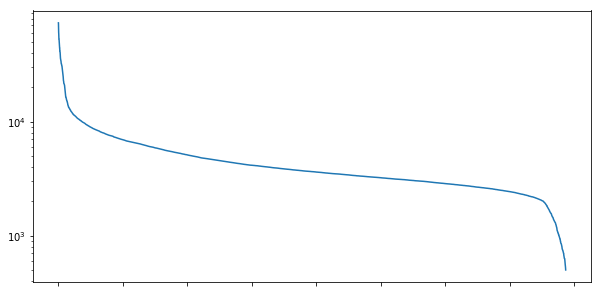

In [31]:
ser_sum = plot_umi_levels(feature_data, feature_type='gex', min_umi=100)

### Filtering
Will also drop barcodes with more than 10,000 UMI.

### Filter Barcodes Based on GEX UMI Sum

In [32]:
%%time
feature_filtered = filter_barcodes_by_umi(feature_data, 'gex', min_umi=100, max_umi=100000000)

CPU times: user 149 ms, sys: 48.3 ms, total: 197 ms
Wall time: 196 ms


In [33]:
check_feature_data_size(feature_filtered)

gex
33538 7865
(33538, 7865) 

adt
14 7865
(14, 7865) 



In [34]:
def filter_ribo_mito_from_gex(df_ini):
    df = deepcopy(df_ini)
    all_genes = df.index.tolist()

    keep_genes = [x for x in all_genes if 'RPL' not in x]
    keep_genes = [x for x in keep_genes if 'RPS' not in x]


    df = df.loc[keep_genes]

    # Removing Mitochondrial Genes
    list_mito_genes = ['MTRNR2L11', 'MTRF1', 'MTRNR2L12', 'MTRNR2L13', 'MTRF1L', 'MTRNR2L6', 'MTRNR2L7',
                    'MTRNR2L10', 'MTRNR2L8', 'MTRNR2L5', 'MTRNR2L1', 'MTRNR2L3', 'MTRNR2L4']


    all_genes = df.index.tolist()
    mito_genes = [x for x in all_genes if 'MT-' == x[:3] or 
                 x.split('_')[0] in list_mito_genes]


    keep_genes = [x for x in all_genes if x not in mito_genes]
    df = df.loc[keep_genes]
    return df

In [35]:
%%time
df = convert_feature_data_to_df_dict(feature_filtered, make_sparse=False)
print('adt', df['adt'].shape)
print('gex', df['gex'].shape)

adt (14, 7865)
gex (33538, 7865)
CPU times: user 387 ms, sys: 598 ms, total: 985 ms
Wall time: 1.4 s


### Drop ribo and mito genes

In [36]:
print(df['gex'].shape)
df['gex-nrm'] = filter_ribo_mito_from_gex(df['gex'])
print(df['gex-nrm'].shape)

(33538, 7865)
(33320, 7865)


# Cytobank Exporting
-----------------------------------
* Make barcodes rows, change to using numeric indexes
* Make surface markers columns
* Add GEX and UMI Sum as Columns
* Add 250 variable genes (excluding ribo and mito) to matrix


In [37]:
df['adt-cyto'] = df['adt'].transpose()
df['adt-cyto'] = df['adt-cyto'].reset_index(drop=True)

df['gex-cyto'] = df['gex-nrm'].transpose()
df['gex-cyto'] = df['gex-cyto'].reset_index(drop=True)

In [38]:
df['adt-cyto'].shape

(7865, 14)

In [39]:
df['gex-cyto'].shape

(7865, 33320)

### Calculate GEX and ADT Sum

In [40]:
ser_gex_sum = df['gex-cyto'].sum(axis=1)
ser_gex_sum.name = 'der_gex-umi-sum'
ser_gex_sum.shape

(7865,)

In [41]:
ser_adt_sum = df['adt-cyto'].sum(axis=1)
ser_adt_sum.name = 'der_adt-umi-sum'
ser_adt_sum.shape

(7865,)

### Get Top 250 Variable Genes

In [42]:
net.load_df(df['gex-cyto'])
net.filter_N_top(inst_rc='col', N_top=250, rank_type='var')
df['gex-var'] = net.export_df()
df['gex-var'].columns = ['gex_' + x for x in df['gex-var'].columns]
df['gex-var'].shape

(7865, 250)

In [43]:
df['gex-var'].head()

,gex_IGKC,gex_IGHA1,gex_IGLC2,gex_IGLC3,gex_IGHM,gex_JCHAIN,gex_IGHA2,gex_IGHG2,gex_MALAT1,gex_S100A9,...,gex_HMGN1,gex_NCF1,gex_ELOB,gex_EIF3E,gex_PTGDS,gex_HLA-DQA2,gex_AQP3,gex_ARPC5,gex_PGK1,gex_GZMK
0,1,1,0,0,0,0,0,0,97,154,...,1,5,5,0,0,0,0,6,1,0
1,1,0,0,0,0,0,0,0,49,309,...,0,1,8,4,0,1,0,1,3,0
2,0,1,0,0,0,0,0,0,50,92,...,0,3,4,0,0,0,0,2,3,0
3,0,0,0,0,0,0,0,0,66,0,...,0,0,0,1,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,137,0,...,0,0,2,0,2,0,0,1,0,0


### Merge Cytobank DataFrame

In [44]:
df['cyto-ini'] = deepcopy(df['adt-cyto'])
df['cyto-ini']['der_gex-umi-sum'] = ser_gex_sum
df['cyto-ini']['der_adt-umi-sum'] = ser_adt_sum

In [45]:
df['cyto-ini'].head()

,CD3,CD4,CD8a,CD14,CD15,CD16,CD56,CD19,CD25,CD45RA,CD45RO,PD-1,TIGIT,CD127,der_gex-umi-sum,der_adt-umi-sum
0,18,138,13,491,61,17,17,3,9,110,74,9,4,7,4696,971
1,30,119,19,472,102,155,248,3,5,125,156,9,9,8,5018,1460
2,18,207,10,1289,128,72,26,8,15,5268,28,20,11,12,2767,7112
3,18,11,17,20,124,1227,491,5,15,4743,28,25,59,16,901,6799
4,5,14,14,19,156,1873,458,4,16,4108,21,28,76,17,2027,6809


In [46]:
df['cyto'] = pd.concat([df['cyto-ini'], df['gex-var']], axis=1)
df['cyto'].shape

(7865, 266)

In [29]:
df['cyto'].head()

,CD3,CD4,CD8a,CD14,CD15,CD16,CD56,CD19,CD25,CD45RA,...,gex_UBB,gex_COX7B,gex_FKBP11,gex_NCF1,gex_HMGN1,gex_CD3E,gex_TMEM258,gex_PGK1,gex_FOSB,gex_PRELID1
0,18,138,13,491,61,17,17,3,9,110,...,1,2,0,5,1,0,0,1,2,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,119,19,472,102,155,248,3,5,125,...,0,2,0,1,0,0,3,3,3,3
3,18,207,10,1289,128,72,26,8,15,5268,...,1,1,0,3,0,0,2,3,7,1
4,18,11,17,20,124,1227,491,5,15,4743,...,0,0,0,0,0,1,0,0,0,0


In [47]:
# base_path = '../../data/big_data/5k_pbmc_raw_feature_v3-chem_v3.0.2-cr/cytobank_export/'
# df['cyto'].to_csv(base_path + 'adt_umi-sum_250-var-gex.csv')

### Save Cytobank Export Data with and without labels

### Save CytoBank Compatible Data

In [31]:
base_path = '../../data/big_data/5k_pbmc_raw_feature_v3-chem_v3.0.2-cr/cytobank_export/'

In [32]:
for inst_type in ['adt']:
    df_mat = pd.DataFrame(feature_filtered[inst_type]['mat'].todense())
    df_mat.to_csv(base_path + inst_type + '_data.csv')
    df_mat.transpose().to_csv(base_path + inst_type + '-t_data.csv')
    
    pd.DataFrame(feature_filtered[inst_type]['features']).to_csv(base_path + inst_type + '_features.csv')
    pd.DataFrame(feature_filtered[inst_type]['barcodes']).to_csv(base_path + inst_type + '_barcodes.csv')

### ADT Levels Z-scored

zscore features
(7767,)


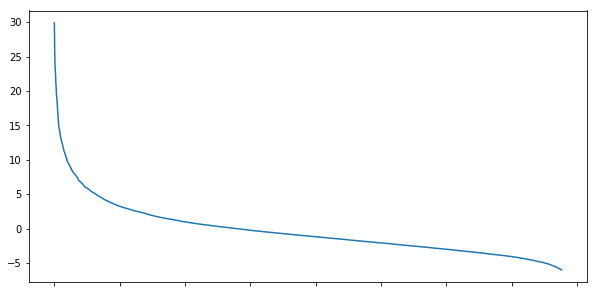

In [48]:
ser_sum = plot_umi_levels(df, feature_type='adt', zscore_features=True, logy=False, 
                          max_umi=30, min_umi=-6)
print(ser_sum.shape)

Set max sum Z-scored UMI level to 20 and min to -4

In [55]:
%%time
df = filter_barcodes_by_umi(df, 'adt', min_umi=-4, max_umi=20, zscore_features=True, make_sparse=False)

z-scoring features


KeyError: "['AAACCCAGTACCGCGT' 'AAACCCAGTATCGAAA' 'AAACCCAGTCGTCATA' ...\n 'TTTGTTGGTTGCATGT' 'TTTGTTGTCGAGTGAG' 'TTTGTTGTCGTTCAGA'] not in index"

In [50]:
df['adt'].shape

(14, 7865)

In [51]:
df['gex'].shape

(33538, 7865)

In [52]:
df['adt-ash'] = np.arcsinh(df['adt']/5)
df['adt-ash'].shape
df['adt-ash'].columns = [(x,) for x in df['adt-ash'].columns]

In [53]:
net.load_df(df['adt-ash'])
net.cluster()
net.dendro_cats(axis='col', dendro_level=4)
net.cluster()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD3", "ini": 14, "clust": 12, "rank": 12, "rankvar": 13, "grou…

In [54]:
net.load_df(df['adt-ash'])
net.normalize(axis='row', norm_type='zscore')
net.cluster()
net.dendro_cats(axis='col', dendro_level=4)
net.cluster()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD3", "ini": 14, "clust": 9, "rank": 11, "rankvar": 9, "group"…

## Cell Types

1: CD8 T Cells

2: CD4+ CD45RO+ T Cells

3: CD4+ CD45RA+ T Cells 

4: Myeloid (CD14)

5: CD15+ CD16+

6: NK Cells (CD56, CD16)

7: B Cells (CD19)

CD15 granulocyte, mcarophage monocyte

In [40]:
df['adt-cat'] = net.export_df()
df['adt-ash-cat'] = deepcopy(df['adt-cat'])
df['adt-ash-cat'].columns = df['adt-cat'].columns.tolist()

In [41]:
net.load_df(df['adt-ash-cat'])
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "CD3", "ini": 14, "clust": 12, "rank": 8, "rankvar": 0, "group"…

In [42]:
df['gex'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 33538 entries, MIR1302-2HG to FAM231C
Columns: 9679 entries, AAACCCAAGATTGTGA to TTTGTTGTCGTTCAGA
dtypes: int64(9679)
memory usage: 2.4+ GB


In [43]:
df['adt'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, CD3 to CD127
Columns: 9679 entries, AAACCCAAGATTGTGA to TTTGTTGTCGTTCAGA
dtypes: int64(9679)
memory usage: 1.0+ MB


### Transfer Categories

In [44]:

cat_cols = df['adt-cat'].columns.tolist()
cat_cols[:3]

[('AAACCCAAGATTGTGA', 'Group 4: cat-5'),
 ('AAACCCAAGGCCTGCT', 'Group 4: cat-1'),
 ('AAACCCACATCGGTTA', 'Group 4: cat-5')]

In [45]:
df['gex-cat'] = deepcopy(df['gex'])
df['gex-cat'].columns = cat_cols

In [46]:
net.load_df(df['gex-cat'])
net.filter_N_top(inst_rc='row', rank_type='var', N_top=100)
net.normalize(axis='row', norm_type='zscore')
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "IGKC", "ini": 100, "clust": 26, "rank": 48, "rankvar": 20, "gr…